# Term Paper

### Part 1

In [42]:
import pandas as pd
import glob as glob

In [43]:
files=glob.glob(f'data/SCE-*-20*.csv')

df_list=[]

waves_number=0

#Loop to read in and append files
for file in files:
    df=pd.read_csv(file,sep=";",parse_dates=['date'])
    df_list.append(df)


sce_df=pd.concat(df_list,ignore_index=True)

# Evaluating unique individuals inside the dataframe 
unique_individuals = sce_df['userid'].nunique() 

# Userid column contains unique identifiers for individuals
print(f"Number of unique individuals: {unique_individuals}")

# Number of rows in the DataFrame 
num_rows = sce_df.shape[0]
print(f"Number of rows in the DataFrame: {num_rows}")

# Setting date as index and sorting
sce_df.set_index('date',inplace=True)
sce_df.sort_index(inplace=True)

# Number of unique survey waves 
unique_waves = sce_df["wid"].nunique()
print(f"Number of unique survey waves: {unique_waves}")

# Finding first and last date in the dataframe, without sorting
first_date = sce_df.index[0]
last_date = sce_df.index[-1]
print(f"First date in the DataFrame: {first_date}")
print(f"Last date in the DataFrame: {last_date}")

def compute_statistics():
    num_individuals = sce_df["userid"].nunique() # Number of Unique userids (individuals)
    num_observations = len(sce_df)               # Total number of observations
    num_waves = sce_df["wid"].nunique()          # Number of Unique survey waves          
    first_date = sce_df.index[0]                 # Earliest survey date
    last_date = sce_df.index[-1]                 # Latest survey date

    # Output the statistics
    print("\nDataset Statistics")
    print(f"Unique individuals: {num_individuals}") 
    print(f"Total observations: {num_observations}")
    print(f"Unique survey waves: {num_waves}")
    print(f"Date range: {first_date.date()} to {last_date.date()}") # date() to show only date, not 00.00.00

compute_statistics()


Number of unique individuals: 23369
Number of rows in the DataFrame: 176101
Number of unique survey waves: 139
First date in the DataFrame: 2013-06-01 00:00:00
Last date in the DataFrame: 2024-12-31 00:00:00

Dataset Statistics
Unique individuals: 23369
Total observations: 176101
Unique survey waves: 139
Date range: 2013-06-01 to 2024-12-31


### Part 2

In [44]:
# Forward-fill numeracy variables for each individual
numeracy_cols = [
    'num_lit_q1_correct', 'num_lit_q2_correct', 'num_lit_q3_correct',
    'num_lit_q5_correct', 'num_lit_q6_correct', 'num_lit_q8_correct', 'num_lit_q9_correct'
]

# Replace blank strings with NaN (if your CSV uses empty fields)
sce_df[numeracy_cols] = sce_df[numeracy_cols].replace("", pd.NA)


# Group by userid, then forward-fill within each person
sce_df[numeracy_cols] = sce_df.groupby('userid')[numeracy_cols].ffill()

#NOTE: Here should add variable for demographics (Female, age, educ), and economic variables (inf,house,prob) for later tasks

# Drop all rows that still have NaN
numeracy_cols.extend(['female','educ','age','inflation','house_price_change','prob_stocks_up'])
sce_df.dropna(subset=numeracy_cols,inplace=True)

#Eliminate 0.1th percentile and 99.9th percentile of answers
numeracy_cols = [
    'num_lit_q1_correct', 'num_lit_q2_correct', 'num_lit_q3_correct',
    'num_lit_q5_correct', 'num_lit_q6_correct', 'num_lit_q8_correct', 'num_lit_q9_correct'
]
lower_bounds=sce_df[numeracy_cols].quantile(0.001)
upper_bounds=sce_df[numeracy_cols].quantile(0.999)  #NOTE:should probably remove outliers from other variables as well
for col in numeracy_cols:                           #NOTE:for example, continuous variables like inflation, house price change, prob stocks up (except age)
    sce_df=sce_df[(sce_df[col]>=lower_bounds[col]) & (sce_df[col]<=upper_bounds[col])] #NOTE: I Believe this should be > and < since task says " drop observations below/above this value."

#Creating a column to determine whether the individual has a bachelor's degree or higher
sce_df['college']=(sce_df['educ']>=3).astype(int)

#Compute the total number of correct numeracy responces
sce_df['numeracy_score']=sce_df[numeracy_cols].sum(axis=1)

#Compute the average numeracy score
percentage=sce_df['numeracy_score'].value_counts(normalize=True)*100
percentage.sort_index(inplace=True)
print(f"Numeracy Score Distribution (%): {percentage}")

#Creating a column to determine if the individual has a higher numeracy score than the median
median_score = sce_df['numeracy_score'].median()
sce_df['num_lit_high'] = (sce_df['numeracy_score'] > median_score).astype(int)

# compute and print statistics again after cleaning
compute_statistics()

Numeracy Score Distribution (%): numeracy_score
0.0     0.122114
1.0     0.659272
2.0     2.001803
3.0     5.189132
4.0     9.538728
5.0    16.398209
6.0    27.388498
7.0    38.702245
Name: proportion, dtype: float64

Dataset Statistics
Unique individuals: 17720
Total observations: 137576
Unique survey waves: 117
Date range: 2015-04-02 to 2024-12-31


In [45]:
import matplotlib.pyplot as plt
#NOTE: Define constants outside the function, or earlier in document
#NOTE: remember to have uniform use of "" not '' in document

# Function to plot bar charts of expectations by group
def plot_expectation_bars_by_group(group_var, group_labels):
   
    # Calculate mean expectations by group_var (eg. female, college, num_lit_high)
    grouped = sce_df.groupby(group_var)[["inflation", "house_price_change", "prob_stocks_up"]].mean()
    grouped.index = group_labels       #NOTE: ["inflation", etc list can be made into variable, and]           

    # Creates sublots for each expectation variable. 
    # Variables fig for the whole figure, axes for each subplot
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    variables = ["inflation", "house_price_change", "prob_stocks_up"] #NOTE: Here too use variable list
    titles = ["Inflation", "House Price", "Stock Market"] # NOTE: use variable list with some .upper() to get titles

    y_labels = ["Inflation (%)", "House Price Change (%)", "Probability Stocks Up (%)"]
    # loops trough i (index) and var (variables) in enumerate of variables list
    for i, var in enumerate(variables):
        # Plots bar chart 
        grouped[var].plot.bar(ax=axes[i], color=['#1f77b4', '#ff7f0e'], rot=0,) #rot=0 to keep x labels horizontal since df.plot.bar defaults to rot=45
        # Sets title and y label for each subplot
        axes[i].set_title(f"{titles[i]} Expectations", fontsize=12, fontweight='bold', pad=15) #maybe remove pad, adds space between title and plot
        axes[i].set_ylabel(y_labels[i]) #NOTE: maybe add fontsize
        # Adds grid lines for better readability
        axes[i].grid(axis='y', linestyle='--', alpha=0.3)
        axes[i].set_axisbelow(True)   # Grid won't obscure data

    plt.tight_layout()
    plt.show()

    

## Gender Comparison

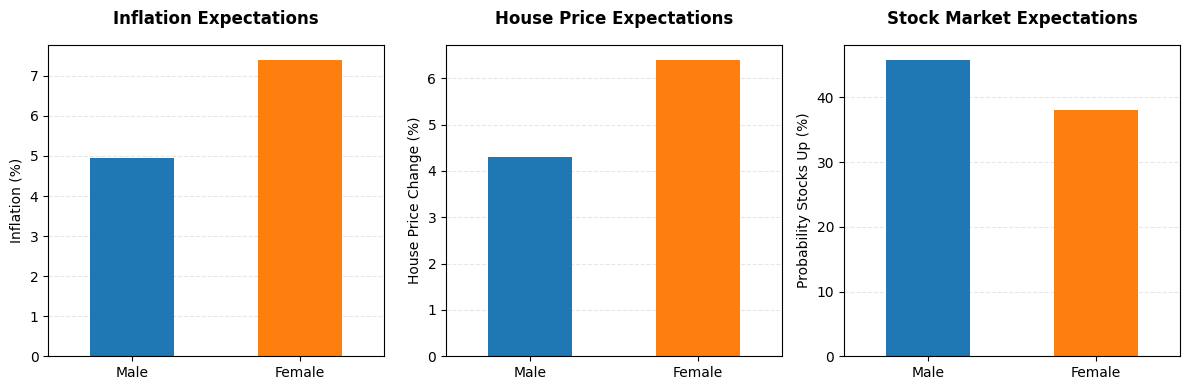

## College Comparison

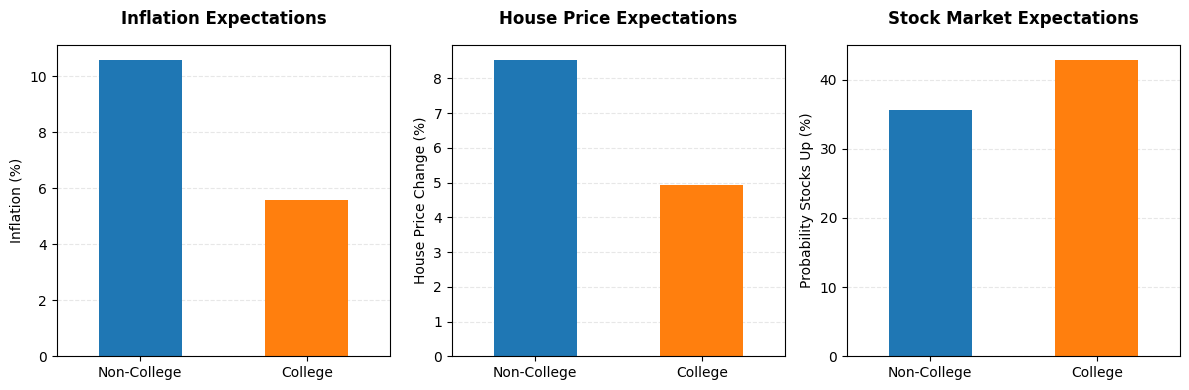

## Numeracy Comparison

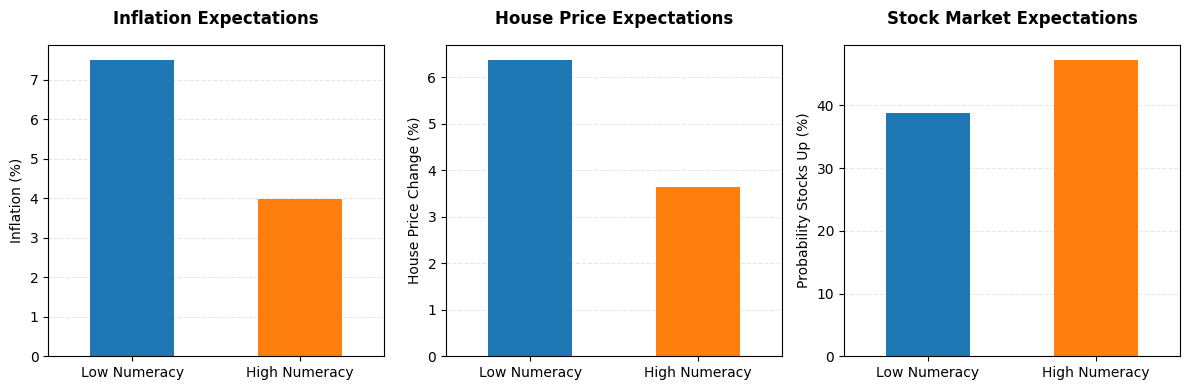

In [46]:
from IPython.display import display, Markdown # Import display to use markdown headers

# Gender Comparison
display(Markdown("## Gender Comparison"))
plot_expectation_bars_by_group('female', ['Male', 'Female'])

# College Comparison
display(Markdown("## College Comparison"))
plot_expectation_bars_by_group('college', ['Non-College', 'College'])

# Numeracy Comparison
display(Markdown("## Numeracy Comparison"))
plot_expectation_bars_by_group('num_lit_high', ['Low Numeracy', 'High Numeracy'])